In [1]:
from __future__ import print_function
from __future__ import division
import os
import cPickle as pickle
import json
import subprocess
from IPython.display import display
from IPython.display import Audio
import bisect
from collections import namedtuple
import numpy as np
import pandas as pd
from collections import Counter
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import nltk
from nltk.corpus import stopwords

from matplotlib.ticker import MultipleLocator, \
     FormatStrFormatter, AutoMinorLocator
%matplotlib inline

In [2]:
np.arange(1,20)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

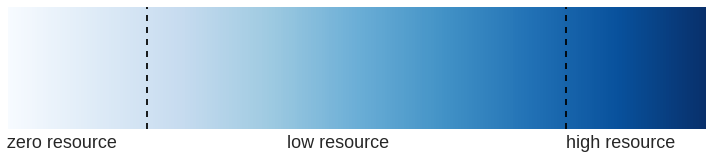

In [3]:
# sns.palplot(sns.color_palette("Blues", 10))

# Set up the matplotlib figure
f, ax1 = plt.subplots(1, 1, figsize=(10, 2), sharex=True)

# Generate some sequential data
x = np.arange(1,1001)
y1 = 2*np.ones(1000)
# sns.barplot(x, y1, palette="Blues_d", edgecolor='0', ax=ax1, width=1)
plt.bar(x, y1, width=1, color=[plt.cm.Blues((1.0*i/len(x))) for i in x], edgecolor='')
# ax1.set_ylabel("Sequential")
ax1.set_xlim(1,1000)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.text(0, -.3, r'zero resource', fontsize=18)
ax1.text(400, -.3, r'low resource', fontsize=18)
ax1.text(800, -.3, r'high resource', fontsize=18)
ax1.axvline(200, linestyle='--', color='k')
ax1.axvline(800, linestyle='--', color='k')
f.tight_layout()
f.savefig("resource.png")

# # Center the data to make it diverging
# y2 = y1 - 5
# sns.barplot(x, y2, palette="RdBu_r", ax=ax2)
# ax2.set_ylabel("Diverging")

In [4]:
with open("config.json") as json_data_file:
    config = json.load(json_data_file)

In [5]:
nodes_fname = config["es"]['nodes_fname']
seg_nodes_fname = config["es"]['seg_nodes_fname']
nodes_dict_fname = config["es"]['nodes_dict_fname']

edges_utd_fname = config["es"]['edges_utd_fname']
edges_olap_fname = config["es"]['edges_olap_fname']
edges_all_fname = config["es"]['edges_all_fname']
edges_score_fname = config["es"]['edges_score_fname']

clusters_utd_fname = config['es']['clusters_utd_fname']
clusters_fname = config['es']['clusters_fname']
clusters_stats_fname = config['es']['clusters_stats_fname']

pairs_fname = config['es']['score_pairs_fname']
eval_fname = config['es']['eval_pairs_fname']

feats_fname = config['es']['feats_fname']

# Gold feats
gold_feats_dict_fname = config['es']['gold_feats']
# Pseudo feats
feats_dict_fname = config['es']['feats_dict_fname']

gold_probs_fname = config['es']['mt_probs_gold']
gold_probs_dict_fname = config['es']['mt_probs_dict_gold']

pseudo_probs_fname = config['es']['mt_probs_pseudo']
pseudo_probs_dict_fname = config['es']['mt_probs_dict_pseudo']

train_segment_list_fname = config['es']['mt_train_files']
dev_segment_list_fname = config['es']['mt_dev_files']

gold_corpus_fname = config['es']['mt_corpus_train_gold']
pseudo_corpus_fname = config['es']['mt_corpus_train_pseudo']

mt_gold_pred_dict_fname = config['es']['mt_gold_pred_dict']
mt_pseudo_pred_dict_fname = config['es']['mt_pseudo_pred_dict']

mt_gold_eval_dict_fname = config['es']['mt_gold_eval_dict']
mt_pseudo_eval_dict_fname = config['es']['mt_pseudo_eval_dict']

es_merge_wavs_path = config['es']['es_merge_wavs']
utd_wavs_path = config['es']['utd_wavs']

utd_tmp_wav_path = config['es']['utd_wavs']

In [6]:
Align = namedtuple('Align', ['word', 'start', 'end'])
Node = namedtuple('Node', ['file', 'seg', 'start', 'end', 'es', 'es_cnt'])
Eval = namedtuple('Eval', ['n1', 'n2', 'dtw', 'es_sim', 'es_cnt_sim', 'en_j_sim'])

In [7]:
segment_map = pickle.load(open(config['es']['segment_dict_fname'], "rb"))
align_dict = pickle.load(open(config['es']['align_dict_fname'], "rb"))
nodes_dict = pickle.load(open(nodes_dict_fname, "rb"))
pairs_list = pickle.load(open(pairs_fname, "rb"))
eval_dict = pickle.load(open(eval_fname, "rb"))
clusters = pickle.load(open(clusters_fname, "rb"))
clusters_stats = pickle.load(open(clusters_stats_fname, "rb"))
feats_dict = pickle.load(open(feats_dict_fname, "rb"))
gold_feats_dict = pickle.load(open(gold_feats_dict_fname, "rb"))

if os.path.exists(gold_probs_dict_fname):
    gold_probs_dict = pickle.load(open(gold_probs_dict_fname, "rb"))

if os.path.exists(pseudo_probs_dict_fname):
    pseudo_probs_dict = pickle.load(open(pseudo_probs_dict_fname, "rb"))

if os.path.exists(mt_gold_pred_dict_fname):
    mt_gold_pred_dict = pickle.load(open(mt_gold_pred_dict_fname, "rb"))
    
if os.path.exists(mt_pseudo_pred_dict_fname):
    mt_pseudo_pred_dict = pickle.load(open(mt_pseudo_pred_dict_fname, "rb"))
    
if os.path.exists(mt_gold_eval_dict_fname):
    mt_gold_eval_dict = pickle.load(open(mt_gold_eval_dict_fname, "rb"))
    
if os.path.exists(mt_pseudo_eval_dict_fname):
    mt_pseudo_eval_dict = pickle.load(open(mt_pseudo_eval_dict_fname, "rb"))    

In [8]:
os.path.exists(mt_gold_pred_dict_fname), mt_gold_pred_dict_fname

(True,
 u'../../../ZRTools/exp/callhome/matches/config0.87-0.90-0.80-50/mt_gold_pred_dict.p')

In [9]:
def gen_node_wav(nid, nodes_dict, utd_wavs_path, src_wavs_path, segment_map):
    pair_wavs_path = os.path.join(utd_wavs_path, "wavs")
    nid_fname = os.path.join(pair_wavs_path, "%d.wav" % nid)
    if not os.path.exists(pair_wavs_path):
        os.makedirs(pair_wavs_path)
    #if os.path.exists(nid_fname):
    #    return
    
    segid = nodes_dict[nid].seg
    fid = (segid.split('.')[0]).strip()
    
    merge_wav_start = segment_map[fid][segid] + nodes_dict[nid].start
    merge_wav_end = segment_map[fid][segid] + nodes_dict[nid].end
    
    merge_wav_fname = os.path.join(src_wavs_path, fid+".wav")
    
    start_time = "{0:0.2f}".format(merge_wav_start/100)
    end_time = "={0:0.2f}".format(merge_wav_end/100)
    subprocess.call(["sox", merge_wav_fname, nid_fname, \
                     "trim", start_time, "{0:s}".format(end_time)])
    
    return Audio(nid_fname)
    
    

In [10]:
display(gen_node_wav(1, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))

In [11]:
def display_pair(pid, eval_dict, nodes_dict, align_dict, utd_wavs_path, src_wavs_path, segment_map):
    headers = ["pair id", "nid", "ES transcript", "EN translation"]
    display_pp = PrettyTable(headers, hrules=True)
    
    n1 = eval_dict[pid].n1
    n2 = eval_dict[pid].n2
    
    en_1 = ' '.join([x.word for x in align_dict[nodes_dict[n1].file][nodes_dict[n1].seg]['en']])
    en_2 = ' '.join([x.word for x in align_dict[nodes_dict[n2].file][nodes_dict[n2].seg]['en']])
    
    row_1 = [pid, n1, ' '.join(nodes_dict[n1].es), textwrap.fill(en_1,50)]
    
    row_2 = [pid, n2, ' '.join(nodes_dict[n2].es), textwrap.fill(en_2,50)]
    
    display_pp.add_row(row_1)
    display_pp.add_row(row_2)
    print(display_pp)
    
    display(gen_node_wav(n1, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))
    display(gen_node_wav(n2, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))
    print(display_pp.get_html_string())

    

In [12]:
segment_map['049']['049.142']

35675

In [13]:
align_dict['001']['001.001']['en']

[Align(word='MECHITA', start=12, end=50),
 Align(word='WHAT', start=50, end=73),
 Align(word='SENT', start=129, end=169),
 Align(word='IT', start=126, end=129),
 Align(word='TO', start=169, end=176),
 Align(word='WHOM', start=176, end=192),
 Align(word='TO', start=192, end=198),
 Align(word='POCHO', start=198, end=225)]

In [14]:
display_pair(16210, eval_dict, nodes_dict, align_dict, utd_wavs_path, es_merge_wavs_path, segment_map)

+---------+-------+------------------------+---------------------------------------------------+
| pair id |  nid  |     ES transcript      |                   EN translation                  |
+---------+-------+------------------------+---------------------------------------------------+
|  16210  | 19997 | CINCO OCHO CUATRO SEIS |                FIVE EIGHT FOUR SIX                |
+---------+-------+------------------------+---------------------------------------------------+
|  16210  | 19998 | CINCO OCHO CUATRO SEIS | EH SEE FOUR THE ONLY THING WANT KNOW IS THAT THAT |
|         |       |                        |   THE PHONE IS RIGHT FOUR EIGHT THREE FIVE EIGHT  |
|         |       |                        |  FOUR SIX IS THE MOST IMPORTANT THING BECAUSE THE |
|         |       |                        |                  WASHINGTON CODE                  |
+---------+-------+------------------------+---------------------------------------------------+


<table>
    <tr>
        <th>pair id</th>
        <th>nid</th>
        <th>ES transcript</th>
        <th>EN translation</th>
    </tr>
    <tr>
        <td>16210</td>
        <td>19997</td>
        <td>CINCO OCHO CUATRO SEIS</td>
        <td>FIVE EIGHT FOUR SIX</td>
    </tr>
    <tr>
        <td>16210</td>
        <td>19998</td>
        <td>CINCO OCHO CUATRO SEIS</td>
        <td>EH SEE FOUR THE ONLY THING WANT KNOW IS THAT THAT<br>THE PHONE IS RIGHT FOUR EIGHT THREE FIVE EIGHT<br>FOUR SIX IS THE MOST IMPORTANT THING BECAUSE THE<br>WASHINGTON CODE</td>
    </tr>
</table>


## Cluster analysis

In [54]:
train_fids = []
with open(train_segment_list_fname, "r") as in_f:
    for line in in_f:
        train_fids.append(line.strip().split(".")[0])
train_fids = set(train_fids)

In [55]:
dev_fids = []
with open(dev_segment_list_fname, "r") as in_f:
    for line in in_f:
        dev_fids.append(line.strip().split(".")[0])
dev_fids = set(dev_fids)

In [57]:
clusters_stats['is_dev'] = []
clusters_stats['is_train'] = []
for fids in clusters_stats['fids']:
    is_in_dev = len(dev_fids & set(fids)) > 0
    is_in_train = len(train_fids & set(fids)) > 0
    clusters_stats['is_dev'].append(is_in_dev)
    clusters_stats['is_train'].append(is_in_train)

In [58]:
eval_df = pd.DataFrame(eval_dict, columns=Eval._fields)
clusters_df = pd.DataFrame(clusters_stats)
del clusters_df['avg_purity']
clusters_df['depth'] = clusters_df.apply(lambda row: len(row['words']), axis=1)

In [16]:
(eval_df.sort_values('dtw', ascending=False, inplace=False)).head(10)

,n1,n2,dtw,es_sim,es_cnt_sim,en_j_sim
16210,19997,19998,0.999,1,1,0.266667
8637,34387,34388,0.999,1,1,0.095238
598,17526,37544,0.999,1,1,0.047619
14292,58275,58287,0.999,1,1,0.222222
3582,14075,14076,0.999,1,1,1.000000
10454,51185,51186,0.999,1,1,0.166667
21587,15745,15746,0.999,1,1,1.000000
1275,19551,19552,0.999,1,1,0.250000
24760,2567,2568,0.999,0,0,0.000000
8186,353,354,0.999,1,1,0.000000


In [17]:
print(len(clusters_df), len(clusters_df[clusters_df['depth'] == 0]))

15533 126


In [18]:
clusters_df[(clusters_df['purity'] >= 0.75) & (clusters_df['depth'] >= 6)].head(10)

,fids,most_common,purity,words,depth
242,"[002, 037, 088, 061, 061, 061, 061, 088, 088, ...",claro,0.923077,"[claro, claro, así, claro, claro, claro, claro...",13
1771,"[012, 012, 012, 082, 037, 037]",así,0.857143,"[así, así, así, casete, así, así, así]",7
2773,"[054, 046, 054, 046, 046, 046]",mmm,0.833333,"[mmm, mmm, mmm, mmm, octubre, mmm]",6
3996,"[061, 061, 061, 088, 061, 111]",bueno,0.857143,"[bueno, bueno, bueno, bueno, bueno, ah, bueno]",7
4337,"[062, 061, 062, 062, 062, 062, 062, 062, 062, ...",claro,1.000000,"[claro, claro, claro, claro, claro, claro, cla...",18
4387,"[062, 064, 064, 018, 064, 040, 064, 040, 040, ...",<laugh>,0.953488,"[importante, <laugh>, <laugh>, <laugh>, <laugh...",43
4645,"[064, 064, 064, 064, 064, 064]",<laugh>,1.000000,"[<laugh>, <laugh>, <laugh>, <laugh>, <laugh>, ...",6
9304,"[014, 014, 014]",doscientos,1.000000,"[doscientos, doscientos, doscientos, dosciento...",6
9307,"[014, 014, 014, 014, 014, 014]",exacto,0.857143,"[pues, exacto, exacto, exacto, exacto, exacto,...",7
9309,"[014, 014, 014, 014, 014, 014, 014, 014, 014, ...",okey,0.823529,"[okey, okey, okey, pueda, okey, okey, okey, ok...",17


In [19]:
(clusters_df.sort_values('purity', ascending=False, inplace=False)).head(10)

,fids,most_common,purity,words,depth
0,"[001, 001]",radioterapista,1.0,"[radioterapista, radioterapista]",2
1452,"[010, 059]",volver,1.0,[volver],1
6639,"[078, 078]",importa,1.0,"[importa, importa]",2
6645,"[078, 078]",preocupes,1.0,"[preocupes, preocupes]",2
6649,"[078, 078]",grabación,1.0,"[grabación, grabación]",2
6659,"[078, 078]",<laugh>,1.0,"[<laugh>, <laugh>]",2
6676,"[078, 088]",seguramente,1.0,[seguramente],1
6708,"[078, 108]",siguiera,1.0,[siguiera],1
6746,"[079, 027]",bueno,1.0,"[bueno, bueno]",2
6753,"[079, 032]",noche,1.0,"[noche, noche]",2


In [20]:
(clusters_df.sort_values('depth', ascending=False, inplace=False)).head(10)

,fids,most_common,purity,words,depth
209,"[002, 015, 002, 031, 002, 037, 002, 039, 002, ...",así,0.032767,"[llamó, miguel, temprano, entonces, contenta, ...",2533
491,"[005, 061, 112, 049, 078, 061, 033, 066, 067, ...",tanta,0.054545,"[totalmente, trucho, cuestan, disparate, toman...",55
945,"[007, 034, 009, 067, 009, 088, 056, 006, 059, ...",regalitos,0.042553,"[empezaste, voy, empezar, diciendo, sumamente,...",47
3839,"[061, 034, 100, 076, 104, 078, 037, 078, 104, ...",cómo,0.088889,"[papá, entonces, pones, sabo, cómo, súper, con...",45
4387,"[062, 064, 064, 018, 064, 040, 064, 040, 040, ...",<laugh>,0.953488,"[importante, <laugh>, <laugh>, <laugh>, <laugh...",43
3217,"[058, 024, 059, 061, 067, 066, 111, 111, 078, ...",ves,0.048780,"[gusta, televisión, televisión, paty, chiquita...",41
1546,"[010, 114, 061, 024, 039, 061, 046, 060, 076, ...",van,0.051282,"[gestionarlo, papi, alegro, dientes, va, viste...",39
838,"[006, 112, 006, 057, 035, 058, 041, 061, 061, ...",si,0.102564,"[iba, saber, si, lunes, martes, ahora, si, va,...",39
1143,"[009, 035, 010, 113, 049, 114, 052, 054, 066, ...",ahí,0.051282,"[sé, pobrecitos, ahí, si, viviendo, haciendo, ...",39
3811,"[061, 024, 024, 039, 061, 042, 042, 045, 061, ...",pedir,0.085714,"[pedir, chelita, terminar, pedir, cumplir, ent...",35


In [33]:
clusters_df['cross_file'] = clusters_df.apply(lambda row: len(set(row['fids'])) > 1, axis=1)

In [42]:
clusters_df['fid_min'] = clusters_df.apply(lambda row: min(row['fids']), axis=1)

In [45]:
clusters_df['fid_max'] = clusters_df.apply(lambda row: max(row['fids']), axis=1)

In [50]:
clusters_df['oov'] = clusters_df.apply(lambda row: max(row['fids']) not in train_fids and \
                                                    min(row['fids']) in dev_fids, axis=1)

In [49]:
dev_fids[:10], train_fids[:10]

(['056', '050', '057', '051', '054', '058', '052', '049', '048', '047'],
 ['076', '077', '075', '072', '073', '070', '071', '090', '091', '092'])

In [59]:
clusters_df.head(10)

,fids,is_dev,is_train,most_common,purity,words,depth
0,"[001, 001]",False,False,radioterapista,1.000000,"[radioterapista, radioterapista]",2
1,"[001, 001]",False,False,conoce,0.500000,"[conversa, conoce]",2
2,"[001, 001]",False,False,maneras,0.333333,"[mandado, todas, maneras]",3
3,"[001, 001]",False,False,ver,0.500000,"[vamos, ver, vamos, ver]",4
4,"[001, 001]",False,False,año,0.666667,"[año, ser, año]",3
5,"[001, 001]",False,False,interpretación,0.400000,"[necesita, interpretación, ley, necesita, inte...",5
6,"[001, 001]",False,False,interpretación,1.000000,"[interpretación, interpretación]",2
7,"[001, 001, 001, 009]",False,False,mandar,0.285714,"[mandado, dónde, mandado, vas, mandar, vamos, ...",7
8,"[001, 001, 023]",False,False,averiguarlo,0.250000,"[averiguar, averiguarlo, dice, dijo]",4
9,"[001, 001]",False,False,variaciones,0.500000,"[operaciones, variaciones]",2


In [36]:
len(clusters_df[clusters_df.cross_file]), len(clusters_df)

(11849, 15533)

In [62]:
len(clusters_df[clusters_df.is_dev])

5298

In [63]:
len(clusters_df[(clusters_df.is_dev == True) & (clusters_df.is_train == False)])

2179

In [22]:
!ls ../../../ZRTools/exp/callhome/tmpwav/

0001.wav   1110.wav   13127.wav  15144.wav  3343.wav  5562.wav	7781.wav
0002.wav   11110.wav  13128.wav  15145.wav  3344.wav  5563.wav	7782.wav
0003.wav   11111.wav  13129.wav  15146.wav  3345.wav  5564.wav	7783.wav
0004.wav   11112.wav  1312.wav	 15147.wav  3346.wav  5565.wav	7784.wav
0005.wav   11113.wav  13130.wav  15148.wav  3347.wav  5566.wav	7785.wav
0006.wav   11114.wav  13131.wav  15149.wav  3348.wav  5567.wav	7786.wav
0007.wav   11115.wav  13132.wav  1514.wav   3349.wav  5568.wav	7787.wav
0008.wav   11116.wav  13133.wav  15150.wav  3350.wav  5569.wav	7788.wav
0009.wav   11117.wav  13134.wav  15151.wav  3351.wav  5570.wav	7789.wav
0010.wav   11118.wav  13135.wav  15152.wav  3352.wav  5571.wav	7790.wav
0011.wav   11119.wav  13136.wav  15153.wav  3353.wav  5572.wav	7791.wav
0012.wav   1111.wav   13137.wav  15154.wav  3354.wav  5573.wav	7792.wav
0013.wav   11120.wav  13138.wav  15155.wav  3355.wav  5574.wav	7793.wav
0014.wav   11121.wav  13139.wav  15156.wav  3356.wav  5575.wav	77

In [23]:
Audio('../../../ZRTools/exp/callhome/tmpwav/0058.wav')

In [24]:
k = 1
uttr = "010.169"
# uttr = "011.178"
# uttr = "002.008"

In [25]:
print(" ".join([w.word.decode("utf-8") for w in align_dict[uttr.split(".")[0]][uttr]['es']]))
print(" ".join([w.word.decode("utf-8") for w in align_dict[uttr.split(".")[0]][uttr]['en_cnt']]))

AH BUENO ESA ES LA CUESTIóN OYE BUENO Y
OH WELL 'S PROBLEM HEY WELL


In [26]:
print(" ".join([w.decode("utf-8") for w in gold_feats_dict[uttr]])),
print(" ".join([w.decode("utf-8") for w in feats_dict[uttr]]))

AH BUENO CUESTIóN OYE BUENO
1354


In [27]:
# pseudo_probs_dict['1354']

In [28]:
print(" ".join([w.decode("utf-8") for w in mt_gold_pred_dict[k][uttr]])),
print(" ".join([w.decode("utf-8") for w in mt_pseudo_pred_dict[k][uttr]]))

OH GOOD CANARIES HEY GOOD



In [29]:
mt_gold_eval_dict['dev'][k][uttr]

KeyError: '010.169'

In [ ]:
mt_pseudo_eval_dict['dev'][k][uttr]

In [ ]:
[(key, v['t']) for key,v in mt_pseudo_eval_dict['dev'][k].items() if type(v) == dict and v['cp'] == 1]

In [ ]:
feats_dict['001.001']

In [ ]:
print("%03d" % (10,))

In [ ]:
aaa = [0.341, 0.185, 0.121]
bbb = [0.583, 0.454, 0.354]

In [ ]:
for x, y in zip(aaa, bbb):
    print((y-x)/x * 100)

## Calculate duration in dev, test, and training sets

In [ ]:
merged_fa_vads_path = config['es']['es_merge_fa_vad']

In [ ]:
dur = {"tot":{}, "ge500ms":{}}

In [ ]:
vad_flist = [os.path.join(merged_fa_vads_path, fil) for fil in os.listdir(merged_fa_vads_path) if fil.endswith(".vad")]

In [ ]:
for vad_fname in vad_flist:
    with open(vad_fname, "r") as in_f:
        dur_key = int(os.path.splitext(os.path.basename(vad_fname))[0])
        dur["tot"][dur_key] = 0
        dur["ge500ms"][dur_key] = 0
        for line in in_f:
            start, end = map(int, line.strip().split())
            dur_ms = ((end-start) * 10)
            dur["tot"][dur_key] += dur_ms
            dur["ge500ms"][dur_key] += (dur_ms if dur_ms >= 500 else 0)
print("Completed calculating durations")

In [ ]:
def check_dur(dur_list, startid, endid):
    filtered_dur = [(f,d) for f, d in dur_list if f >= startid and f <= endid]
    dur = sum([d for f, d in filtered_dur])
    return filtered_dur, dur/(1000 * 3600)

In [ ]:
# Train set duration
train_dur_list, t_dur = check_dur(dur["tot"].items(), 41, 120)
train_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 41, 120)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in train_dur_500ms_list if d > 0])
print(t_files, len(train_dur_500ms_list))

In [ ]:
# dev set duration
dev_dur_list, d_dur = check_dur(dur["tot"].items(), 1, 20)
dev_dur_500ms_list, d_dur_500ms = check_dur(dur["ge500ms"].items(), 1, 20)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(d_dur, d_dur_500ms))
d_files = sum([1 for f, d in dev_dur_500ms_list if d > 0])
print(d_files, len(dev_dur_500ms_list))

In [ ]:
# test set duration
print("total dur (hrs) %.3f" % (sum([d for f, d in dur["tot"].items() if f >= 21 and f <= 40]) / (1000 * 3600)))
print("total dur (hrs) %.3f" % (sum([d for f, d in dur["ge500ms"].items() if f >= 21 and f <= 40]) / (1000 * 3600)))

test_dur_list, t_dur = check_dur(dur["tot"].items(), 21, 40)
test_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 21, 40)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in test_dur_500ms_list if d > 0])
print(t_files, len(test_dur_500ms_list))

## Fisher

In [ ]:
fish_path = "../../fisher/"
fish_flist_fname = "../../fisher/goodfiles-gdfa.txt"
fish_es_align_path = os.path.join(fish_path, "wav2es-word-final")
fish_subfolders = [os.path.join(fish_es_align_path, f) for f in map(str, range(8))]

In [ ]:
es_words = [a.word for fid in align_dict for sid in align_dict[fid] for a in align_dict[fid][sid]['es']]
es_cnt_words = [a.word for fid in align_dict for sid in align_dict[fid] for a in align_dict[fid][sid]['es_cnt']]
en_words = [a.word for fid in align_dict for sid in align_dict[fid] for a in align_dict[fid][sid]['en']]
en_cnt_words = [a.word for fid in align_dict for sid in align_dict[fid] for a in align_dict[fid][sid]['en_cnt']]

In [ ]:
print(len(es_words), len(set(es_words)))
print(len(es_cnt_words), len(set(es_cnt_words)))
print(len(en_words), len(set(en_words)))
print(len(en_cnt_words), len(set(en_cnt_words)))

In [ ]:
def fisher_get_details(transcript_path):
    es_words = []
    fids = []
    dur = 0
    dur_500ms = 0
    for fname in [f for f in os.listdir(transcript_path) if f.endswith(".es")]:
        fids.append(os.path.splitext(fname)[0].split("_")[2])
        with open(os.path.join(transcript_path, fname), "r") as in_f:
            for line in in_f:
                line_items = line.strip().split()
                start, end = map(float, line_items[1:])
                es_words.append(line_items[0])
                curr_dur = end-start
                dur += curr_dur
                dur_500ms += curr_dur if curr_dur >= 0.5 else 0
    print("finished")
    return es_words, fids, dur, dur_500ms
                
            

In [ ]:
# fish_es, fish_fids, fish_dur, fish_dur_500ms = fisher_get_details(fish_subfolders[0])
fish_es = []
fish_fids = set()
fish_dur = 0
fish_dur_500ms = 0
for subfolder in fish_subfolders[2:3]:
    temp_es, temp_fids, temp_dur, temp_dur_500ms = fisher_get_details(subfolder)
    fish_es.extend(temp_es)
    fish_fids |= set(temp_fids)
    fish_dur += temp_dur
    fish_dur_500ms += temp_dur_500ms
    print("missing es: %d" % len(set(es_words)-set(temp_es)))
    print("dur, total: %.2f, 500ms: %.2f" % (temp_dur / 3600, temp_dur_500ms / 3600))

In [ ]:
fish_es_cnt = [w for w in list(set(fish_es)) if w.lower().decode("utf-8") not in set(stopwords.words('spanish'))]
    
print("#es: %d, set: %d, #fids: %d" % (len(fish_es), len(set(fish_es)), len(set(fish_fids))))
print("tots dur: %.2f, min 500ms dur: %.2f" %(fish_dur / 3600, fish_dur_500ms / 3600))
print("# es cnt: %d," % (len(set(fish_es_cnt))))

In [ ]:
print("missing es\t%d, overlap: %.1f%%" % (len(set(es_words) - set(fish_es)), (len(set(es_words) & set(fish_es)) / len(set(es_words)) * 100)))
print("missing es cnt\t%d" % len(set(es_cnt_words) - set(fish_es_cnt)))

In [ ]:
len(fish_fids)

In [ ]:
[os.path.splitext(f)[0] for f in os.listdir(os.path.join(fish_es_align_path, "0"))[:5]]